In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# PyDrive reference:
# https://googledrive.github.io/PyDrive/docs/build/html/index.html


# 2. Load a file by ID
json_import = drive.CreateFile({'id':'<file_id>'})
json_import.GetContentFile('total_images.npy')


In [2]:
!ls

datalab  ground_truth_resized.npy


In [3]:
import keras
from keras.layers import Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import UpSampling2D
from keras.layers import Concatenate
from keras.layers import Lambda 
from keras.utils import to_categorical
import tensorflow as tf
from keras.layers import Add 

from keras.layers import Reshape

from keras import backend as K
from keras import regularizers, optimizers
%matplotlib inline

Using TensorFlow backend.


In [0]:
import scipy.io as scio
import numpy as np    
import os
import matplotlib.pyplot as plt
import math
import re
from scipy.misc import imsave
from scipy import ndimage, misc
from numpy import unravel_index
from operator import sub
from keras.callbacks import ReduceLROnPlateau, CSVLogger,EarlyStopping,ModelCheckpoint

In [0]:
# Load the data
x = np.load('total_images.npy')
y = np.load('ground_truth_resized.npy')

In [8]:
# Get training indices
train_indices = np.random.choice(2000,1500,replace = False)
print(sorted(train_indices))
x_train_images = []
y_train_labels = [] 
for i in train_indices:
    x_train_images.append(x[i])
    y_train_labels.append(y[i])

test_indices = [xy for xy in range(2000) if xy not in train_indices]
print(test_indices)
x_test_images = []
y_test_labels = []

for i in test_indices:
    x_test_images.append(x[i])
    y_test_labels.append(y[i])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35, 36, 37, 39, 41, 42, 44, 46, 48, 49, 50, 51, 54, 56, 57, 59, 62, 63, 64, 65, 66, 70, 71, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120, 122, 124, 126, 127, 128, 130, 131, 132, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 150, 151, 152, 154, 155, 156, 157, 158, 159, 160, 161, 163, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 186, 187, 189, 190, 191, 192, 193, 195, 197, 198, 199, 200, 201, 202, 203, 206, 207, 208, 209, 211, 212, 213, 215, 216, 218, 219, 220, 221, 222, 223, 225, 227, 229, 230, 233, 237, 239, 242, 243, 244, 245, 246, 247, 248, 249, 253, 254, 256, 258, 259, 260, 263, 264, 265, 266, 268, 270, 271, 272, 273, 274, 276, 277, 278, 279, 280, 28

In [0]:
# set train and test data
x_train = np.array(x_train_images)
x_test = np.array(x_test_images)
y_train = np.array(y_train_labels)
y_test = np.array(y_test_labels)

In [0]:
# setting test as int values
y_test = y_test.astype('uint8')

In [0]:
# Calculate z score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

In [0]:
# save data
np.save("x_train2.npy",x_train)
np.save("x_test2.npy", x_test)
np.save("y_train2.npy",y_train)
np.save("y_test2.npy", y_test)

In [13]:
!ls

datalab			  total_images.npy  x_train2.npy  y_train2.npy
ground_truth_resized.npy  x_test2.npy	    y_test2.npy


In [0]:
# load the saved data
x_train = np.load('x_train2.npy')
x_test = np.load('x_test2.npy')
y_train = np.load('y_train2.npy')
y_test = np.load('y_test2.npy')

In [15]:
# Define the network for segmentation
rows = 256
cols = 256
data_shape = 216*64
weight_decay = 0.0001

inputs = Input(shape=(None,None,3))

L1 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(inputs)
L2 = BatchNormalization()(L1)
L2 = Activation('relu')(L2)

L3 = MaxPooling2D(pool_size=(2,2))(L2)
L4 = Conv2D(128,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L3)
L5 = BatchNormalization()(L4)
L5 = Activation('relu')(L5)

L6 = MaxPooling2D(pool_size=(2,2))(L5)
L7 = Conv2D(128,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L6)
L8 = BatchNormalization()(L7)
L9 = Activation('relu')(L8)
L10 = Conv2D(128,(3,3),dilation_rate= (2,2), padding = "same", activation='relu', name = "conv_dil_1")(L9)
L11 = BatchNormalization()(L10)
L12 = Activation('relu')(L11)
L13 = Conv2D(128,(3,3),dilation_rate= (4,4), padding = "same", activation='relu', name = "conv_dil_2")(L12)
L14 = BatchNormalization()(L13)
L15 = Activation('relu')(L14)
L16 = Conv2D(128,(3,3),dilation_rate= (8,8), padding = "same", activation='relu', name = "conv_dil_3")(L15)
L17 = BatchNormalization()(L16)
L18 = Activation('relu')(L17)
L19 = Conv2D(128,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay),
             name="skip_conv_1")(L6)
L20 = Add()([L18,L19])
L21 = UpSampling2D( size = (2,2)) (L20)

L21 = Conv2D(128,(3,3), padding = "same", kernel_regularizer=regularizers.l2(weight_decay))(L21)
L22 = BatchNormalization()(L21)
L23 = Activation('relu')(L22)
L24 = Conv2D(128,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay),
             name="skip_conv_2")(L3)
L24 = Add()([L23,L24])
L25 = UpSampling2D(size = (2,2))(L24)
L25 = Conv2D(64, (3,3), padding = "same", kernel_regularizer=regularizers.l2(weight_decay))(L25)
 
L26 = BatchNormalization()(L25)
L27 = Activation('relu')(L26)
L28 = Conv2D(1,kernel_size=(1,1),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L27)#

L30 = Activation('sigmoid')(L28)
model = Model(inputs = inputs, outputs = L30)
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 6 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 6 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [0]:
# reshape 
y_train = y_train.reshape(y_train.shape[0],256,256,1)
y_test = y_test.reshape(y_test.shape[0],256,256,1)
smooth = 1

In [0]:
# loss metrics

def customized_loss(y_true,y_pred):
    return (1*K.binary_crossentropy(y_true, y_pred))+(0.5*dice_coef_loss(y_true, y_pred))

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


In [18]:
# executing the model and Callback functions for conditions
optimiser = optimizers.Adam(lr = 0.01)
model.compile(optimizer=optimiser,loss=dice_coef_loss,metrics=['accuracy',dice_coef])

lr_reducer = ReduceLROnPlateau(factor=0.5, cooldown=0, patience=6, min_lr=0.5e-6)
csv_logger = CSVLogger('segmentation_lr_e2_bs4.csv')
model_chekpoint = ModelCheckpoint("segmentation_lr_e2_bs4.hdf5",monitor = 'val_loss',verbose = 1,save_best_only=True)

model.fit(x_train,y_train,batch_size=4,epochs=200,validation_data=(x_test, y_test),callbacks=[lr_reducer, csv_logger,model_chekpoint])

Train on 1500 samples, validate on 500 samples
Epoch 1/200
1500/1500 [==============================] - 5440s 4s/step - loss: -0.5447 - acc: 0.8517 - dice_coef: 0.6133 - val_loss: -0.5161 - val_acc: 0.8221 - val_dice_coef: 0.5844

Epoch 00001: val_loss improved from inf to -0.51613, saving model to segmentation_lr_e2_bs4.hdf5
Epoch 2/200
 332/1500 [=====>........................] - ETA: 1:01:47 - loss: -0.5671 - acc: 0.8705 - dice_coef: 0.6528

1500/1500 [==============================] - 5427s 4s/step - loss: -0.6004 - acc: 0.8831 - dice_coef: 0.6805 - val_loss: -0.4597 - val_acc: 0.8728 - val_dice_coef: 0.5278

Epoch 00002: val_loss did not improve
Epoch 3/200
 840/1500 [===============>..............] - ETA: 35:06 - loss: -0.6824 - acc: 0.9065 - dice_coef: 0.7371

1500/1500 [==============================] - 5409s 4s/step - loss: -0.6815 - acc: 0.9076 - dice_coef: 0.7369 - val_loss: -0.5484 - val_acc: 0.8882 - val_dice_coef: 0.5883

Epoch 00003: val_loss improved from -0.51613 to -0.54837, saving model to segmentation_lr_e2_bs4.hdf5
Epoch 4/200
 836/1500 [===============>..............] - ETA: 37:44 - loss: -0.7256 - acc: 0.9156 - dice_coef: 0.7661

1500/1500 [==============================] - 5496s 4s/step - loss: -0.7315 - acc: 0.9184 - dice_coef: 0.7707 - val_loss: -0.6609 - val_acc: 0.9124 - val_dice_coef: 0.6989

Epoch 00004: val_loss improved from -0.54837 to -0.66094, saving model to segmentation_lr_e2_bs4.hdf5
Epoch 5/200
 836/1500 [===============>..............] - ETA: 36:13 - loss: -0.7535 - acc: 0.9244 - dice_coef: 0.7872

1500/1500 [==============================] - 5398s 4s/step - loss: -0.7582 - acc: 0.9245 - dice_coef: 0.7871 - val_loss: -0.5667 - val_acc: 0.8968 - val_dice_coef: 0.5945

Epoch 00005: val_loss did not improve
Epoch 6/200
 788/1500 [==============>...............] - ETA: 38:49 - loss: -0.7636 - acc: 0.9263 - dice_coef: 0.7894

KeyboardInterrupt: ignored

In [20]:
!ls

datalab			    segmentation_lr_e2_bs4.hdf5  x_train2.npy
ground_truth_resized.npy    total_images.npy		 y_test2.npy
segmentation_lr_e2_bs4.csv  x_test2.npy			 y_train2.npy


In [0]:
# Upload the segmentation weights to Drive. See:
#
# https://developers.google.com/drive/v3/reference/files/create
# https://developers.google.com/drive/v3/web/manage-uploads
from google.colab import auth
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')
from googleapiclient.http import MediaFileUpload

file_metadata = {
  'name': 'segmentation_lr_e2_bs4.csv',
}
media = MediaFileUpload('segmentation_lr_e2_bs4.csv', 
                        resumable=True)
created = drive_service.files().create(body=file_metadata,
                                       media_body=media,
                                       fields='id').execute()
print('File ID: {}'.format(created.get('id')))

In [0]:
# load the above model
model.load_weights('segmentation_lr_e2_bs4.hdf5')

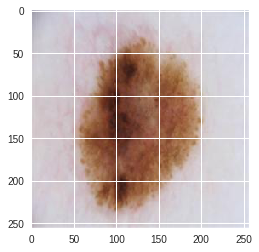

In [38]:
plt.imshow(x[7])

In [0]:

gt = y_test[7].reshape((256,256))
testing_image = x_test[7].reshape((1,256,256,3))
prediction = model.predict(testing_image)
prediction = prediction.reshape((256,256))
test_sample = prediction > 0.5

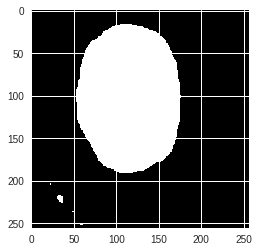

In [40]:
plt.imshow(test_sample, cmap = "gray")

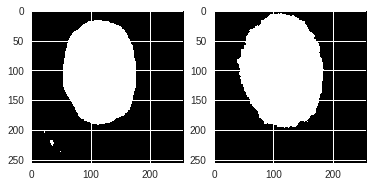

In [54]:
plt.subplot(1,2,1)
plt.imshow(test_sample, cmap = "gray")
plt.subplot(1,2,2)
plt.imshow(gt, cmap = "gray")

